/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


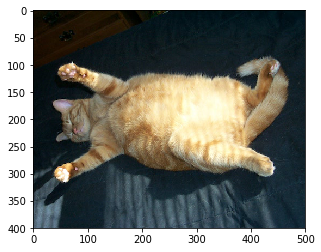

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mxnet import image

img = image.imdecode(open('../img/cat1.jpg', 'rb').read())
plt.imshow(img.asnumpy())

In [2]:
from mxnet import nd
import sys
sys.path.append('..')
import utils

def apply(img, aug, n = 3):
    X = [aug(img.astype('float32')) for _ in range(n * n)]
    Y = nd.stack(*X).clip(0, 255) / 255
    utils.show_images(Y, n, n, figsize = (8, 8))

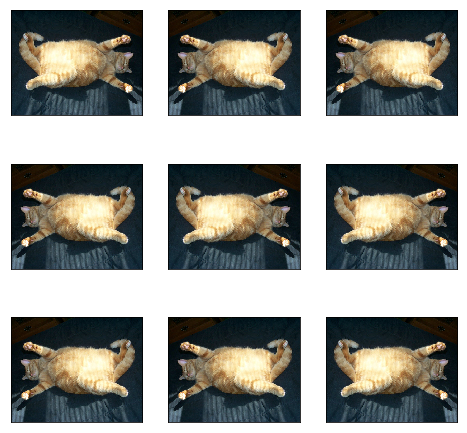

In [3]:
aug = image.HorizontalFlipAug(.5)
apply(img, aug)

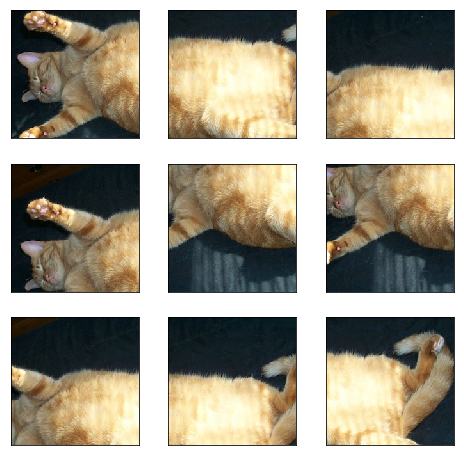

In [4]:
aug  = image.RandomCropAug([200, 200])
apply(img, aug)

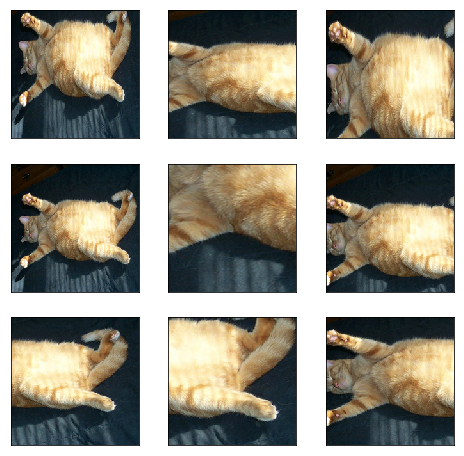

In [5]:
aug = image.RandomSizedCropAug((200, 200), .1, (.5, 2))
apply(img, aug)

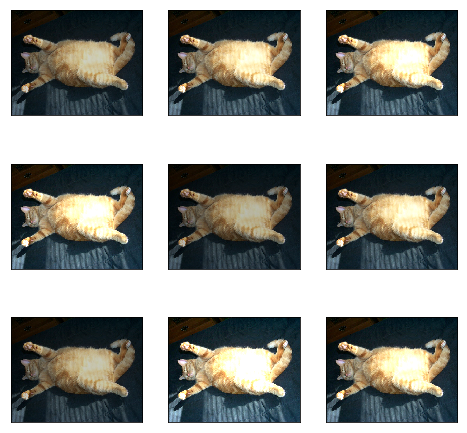

In [6]:
aug = image.BrightnessJitterAug(.5)
apply(img, aug)

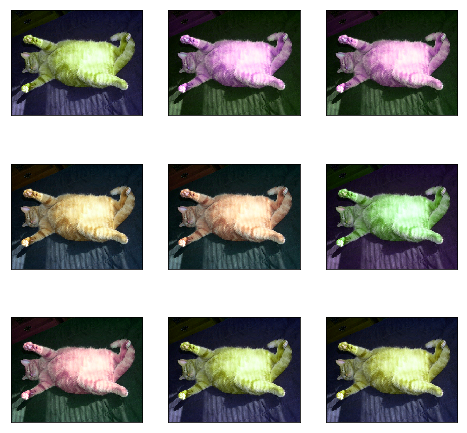

In [7]:
aug = image.HueJitterAug(.5)
apply(img, aug)

In [8]:
def apply_aug_list(img, augs):
    for f in augs:
        img = f(img)
    return img

In [9]:
train_augs = [
    image.HorizontalFlipAug(.5), 
    image.RandomCropAug((28, 28))
]

test_augs = [
    image.CenterCropAug((28, 28))
]

In [10]:
from mxnet import gluon
from mxnet import nd
import sys
sys.path.append('..')
import utils

def get_transform(augs):
    def transform(data, label):
        # data: sample x height x width x channel
        # label: sample
        data = data.astype('float32')
        if augs is not None:
            # apply to each sample one-by-one and then stack
            data = nd.stack(*[
                apply_aug_list(d, augs) for d in data
            ])
        data = nd.transpose(data, (0, 3, 1, 2))
        return data, label.astype('float32')
    return transform

def get_data(batch_size, train_augs, test_augs = None):
    cifar10_train = gluon.data.vision.CIFAR10(
        train = True, transform = get_transform(train_augs))
    cifar10_test = gluon.data.vision.CIFAR10(
        train = False, transform = get_transform(test_augs))
    train_data = utils.DataLoader(
        cifar10_train, batch_size, shuffle = True)
    test_data = utils.DataLoader(
        cifar10_test, batch_size, shuffle = False)
    return (train_data, test_data)

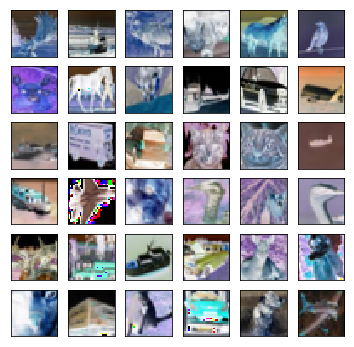

In [11]:
train_data, _ = get_data(36, train_augs)
for imgs, _ in train_data:
    break
utils.show_images(imgs.transpose((0, 2, 3, 1)), 6, 6)

In [12]:
imgs.shape

(36, 3, 28, 28)

In [13]:
from mxnet import init

def train(train_augs, test_augs, learning_rate = .1):
          batch_size = 128
          num_epochs = 10
          ctx = utils.try_all_gpus()
          loss = gluon.loss.SoftmaxCrossEntropyLoss()
          train_data, test_data = get_data(
              batch_size, train_augs, test_augs)
          net = utils.resnet18(10)
          net.initialize(ctx = ctx, init = init.Xavier())
          net.hybridize()
          trainer = gluon.Trainer(net.collect_params(), 
                                  'sgd', {'learning_rate': learning_rate})
          utils.train(
              train_data, test_data, net, loss, trainer, ctx, num_epochs)

In [14]:
train(train_augs, test_augs)

Start training on  [gpu(0)]
Epoch 0. Loss: 1.494, Train acc 0.46, Test acc 0.57, Time 12.1 sec
Epoch 1. Loss: 1.066, Train acc 0.62, Test acc 0.66, Time 12.0 sec
Epoch 2. Loss: 0.885, Train acc 0.69, Test acc 0.70, Time 12.2 sec
Epoch 3. Loss: 0.770, Train acc 0.73, Test acc 0.73, Time 12.1 sec
Epoch 4. Loss: 0.688, Train acc 0.76, Test acc 0.77, Time 11.9 sec
Epoch 5. Loss: 0.632, Train acc 0.78, Test acc 0.77, Time 12.1 sec
Epoch 6. Loss: 0.581, Train acc 0.80, Test acc 0.77, Time 12.0 sec
Epoch 7. Loss: 0.542, Train acc 0.81, Test acc 0.79, Time 12.1 sec
Epoch 8. Loss: 0.510, Train acc 0.82, Test acc 0.77, Time 12.0 sec
Epoch 9. Loss: 0.481, Train acc 0.83, Test acc 0.80, Time 12.0 sec


In [15]:
train(test_augs, test_augs)

Start training on  [gpu(0)]
Epoch 0. Loss: 1.434, Train acc 0.49, Test acc 0.59, Time 11.3 sec
Epoch 1. Loss: 0.978, Train acc 0.66, Test acc 0.63, Time 11.0 sec
Epoch 2. Loss: 0.756, Train acc 0.74, Test acc 0.69, Time 11.1 sec
Epoch 3. Loss: 0.592, Train acc 0.79, Test acc 0.72, Time 11.0 sec
Epoch 4. Loss: 0.452, Train acc 0.84, Test acc 0.72, Time 11.2 sec
Epoch 5. Loss: 0.340, Train acc 0.88, Test acc 0.74, Time 11.1 sec
Epoch 6. Loss: 0.248, Train acc 0.91, Test acc 0.72, Time 11.1 sec
Epoch 7. Loss: 0.167, Train acc 0.94, Test acc 0.69, Time 11.1 sec
Epoch 8. Loss: 0.117, Train acc 0.96, Test acc 0.71, Time 11.2 sec
Epoch 9. Loss: 0.085, Train acc 0.97, Test acc 0.73, Time 11.1 sec
